# Basic Setup

Set up Basic Parameter here

In [27]:
import numpy as np
import random
from mv_laplace import MvLaplaceSampler
import matplotlib.pyplot as plt
import pandas as pd


In [28]:
# Define sample size
N = 20000 # number of subjects
N_T = 10000 # number of treated subjects

# Define betas
beta_11 = 2
beta_12 = 2
beta_21 = 2
beta_22 = 2
beta_23 = 2
beta_31 = 2


#Mask rate - (30%-50%)
lambda1 = 100
lambda2 = 25
lambda3 = 12

#Define strata size
N_S = 100


# Simulate X
The observed covariates for the $n$-th subject $(X_{n1}, X_{n2}, X_{n3}, X_{n4}, X_{n5})$ are i.i.d. generated through the following process: 


$    (X_{n1}, X_{n2})\sim \mathcal{N}\left[\left(\begin{array}{c}
\frac{1}{2}\\
-\frac{1}{3}
\end{array}\right),\left(\begin{array}{cc}
1 & \frac{1}{2} \\
\frac{1}{2} & 1 
\end{array}\right)\right], (X_{n3}, X_{n4})\sim \text{Laplace}\left[\left(\begin{array}{c}
0\\
\frac{1}{\sqrt{3}}
\end{array}\right),\left(\begin{array}{cc}
1 & \frac{1}{\sqrt{2}} \\
\frac{1}{\sqrt{2}} & 1 
\end{array}\right)\right],
$
$X_{n5} \sim \text{Bernoulli}(1/3)$, for $n=1,\dots, N$



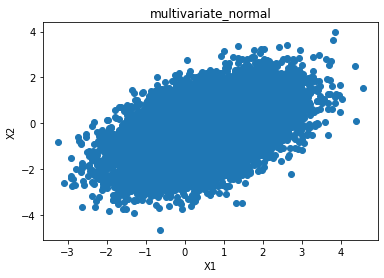

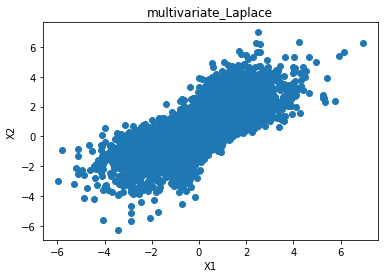

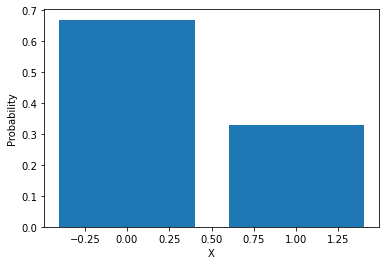

[[-0.32696132  0.6812368   0.57275731  0.97233686  1.        ]
 [-0.0409212  -1.53953593 -1.2914223  -0.05561176  1.        ]
 [-0.46973167 -1.92384538  2.55519608  1.54008559  0.        ]
 ...
 [ 0.92881396  0.63672565  0.6009202   0.4358038   0.        ]
 [-0.2359643  -2.12476425 -1.62639003  0.58875854  0.        ]
 [ 1.46523275  1.02681183  2.53959772  1.25383226  1.        ]]


In [29]:
# generate Xn1 and Xn2
mean = [1/2, -1/3]
cov = [[1, 1/2], [1/2, 1]]
X1_2 = np.random.multivariate_normal(mean, cov, N)
plt.scatter(X1_2[:, 0], X1_2[:, 1])
plt.xlabel('X1')
plt.ylabel('X2')
plt.title("multivariate_normal")
plt.show()

# generate Xn3 and Xn4
loc = [0, 1/np.sqrt(3)]
cov = [[1,1/np.sqrt(2)], [1/np.sqrt(2),1]]

sampler = MvLaplaceSampler(loc, cov)
X3_4 = sampler.sample(N)
plt.scatter(X3_4[:, 0], X3_4[:, 1])
plt.xlabel('X1')
plt.ylabel('X2')
plt.title("multivariate_Laplace")
plt.show()

# generate Xn5
p = 1/3
X5 = np.random.binomial(1, p, N)

counts = np.unique(X5, return_counts=True)
plt.bar(counts[0], counts[1]/N)
plt.xlabel('X')
plt.ylabel('Probability')
plt.show()

# combine all generated variables into a single matrix
X = np.hstack((X1_2, X3_4, X5.reshape(-1,1)))

print(X)

# Simulate U

The unobserved covariates for the $n$-th subject $(U_{n1}, U_{n2})$ are i.i.d. generated through the following process: $U_{n1}\sim N(1/2, 1)$ and $U_{n2}\sim \text{Bernoulli}(2/3)$, for $n=1,\dots, N$.

In [30]:
# generate Un1
mean = 1/2
std = 1
U_n1 = np.random.normal(mean, std, N)

# generate Un2
U_n2 = np.random.binomial(1, 2/3, N)

U = np.concatenate((U_n1.reshape(-1, 1), U_n2.reshape(-1, 1)), axis=1)

print(U.shape)
print(U_n1.shape, U_n2.shape)
print(U[:,0].shape, U[:,1].shape)


(20000, 2)
(20000,) (20000,)
(20000,) (20000,)


# Simulate S

S is the strata index, range from 1 to N_S(how many strata we indicate), each strata has groupSize = int(N / N_S)

In [31]:
# Add strata index
groupSize = int(N / N_S)
S = np.zeros(N)
for i in range(N_S):
    S[groupSize*i:groupSize*(i+1)] = i + 1
S = S.reshape(-1, 1)
display(pd.DataFrame(S))

,0
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0
...,...
19995,100.0
19996,100.0
19997,100.0
19998,100.0


# Simulate Z
   In a stratified randomized experiment, the treatment assignments are random within
each stratum 
$ P(\mathbf{Z}=\mathbf{z}\mid \mathcal{Z})=\prod_{i=1}^{I}{J \choose J_{T}}^{-1}, \quad \forall \mathbf{z}\in \mathcal{Z}.$

In [32]:
Z = []
np.random.shuffle(Z)
groupSize = int(N / N_S)

for i in range(N_S):
    Z.append(np.random.binomial(1, 0.5, groupSize))

Z = np.concatenate(Z).reshape(-1, 1)
print(pd.DataFrame(Z).describe())

                  0
count  20000.000000
mean       0.500300
std        0.500012
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        1.000000


# Simulate Y

The three outcomes of interest $(Y_{n1}, Y_{n2}, Y_{n3})$ are generated via the following process (for $n=1,\dots, N$):

\begin{align*}
    
    &Y_{n1}= \beta_{11} Z_{n}+\beta_{12}Z_{n}\cdot \sum_{p=1}^{5}\sqrt{p}\cdot \exp(X_{np})+\sum_{p=1}^{5}\sum_{p^{\prime}=1}^{5}X_{np} X_{np^{\prime}}^{2}+\sin(U_{n1})+U_{n2},\\
    &Y_{n2}= \beta_{21} Z_{n} + \beta_{22}Z_{n} X_{n1}+ \beta_{23}Z_{n} U_{n1}U_{n2}+\sum_{p=1}^{5}(\cos{p})\cdot X_{np}+\sum_{p=1}^{5}\sum_{p^{\prime}=1}^{5}X_{np}\cdot \exp(X_{np^{\prime}}),  \\
    &Y_{n3}= \beta_{31} Z_{n} + \sum_{p=1}^{5}(\sin{p})\cdot X_{np}+\sum_{p=1}^{5}\sum_{p^{\prime}=1}^{5}\sum_{p^{\prime\prime}=1}^{5}X_{np} X_{np^{\prime}}\exp(X_{np^{\prime\prime}})+X_{n1} X_{n2}\cdot \sin (U_{n1}U_{n2}).
   
\end{align*}
    

In [33]:

#def sum1():
sum1 = np.zeros(N)
for p in range(1,6):
  sum1 += np.sqrt(p) * np.exp(X[:,p-1])

#def sum2():
sum2 = np.zeros(N)
for p in range(1,6):
  for p_2 in range(1,6):
    sum2 += X[:,p-1] * np.power(X[:,p_2-1],2)

#def sum3():
sum3 = np.zeros(N)

for p in range(1,6):
  sum3 += np.cos(p) * X[:,p-1]

#def sum4():
sum4 = np.zeros(N)
for p in range(1,6):
  for p_2 in range(1,6):
    sum4 += X[:,p-1] * np.exp(X[:,p_2-1])

#def sum5():
sum5 = np.zeros(N)
for p in range(1,6):
  sum5 += np.sin(p) * X[:,p-1]

#def sum6(): 
sum6 = np.zeros(N)
for p in range(1,6):
  for p_2 in range(1,6):
    for p_3 in range(1,6):
      sum6 += X[:,p-1] * X[:,p_2-1] * np.exp(X[:,p_3-1])

Z_New = Z.reshape(-1, )

# Calculate Y_n1
Y_n1 = (beta_11 * Z_New + beta_12 * Z_New * sum1   + sum2 + np.sin(U_n1) + U_n2) 

# Compute Yn2
Y_n2 = (beta_21 * Z_New + beta_22 * Z_New * X[:,0] + beta_23 * Z_New * U_n1 * U_n2 + sum3 + sum4) 

# Compute Yn3
Y_n3 = (beta_31 * Z_New + sum5 + sum6 + X[:,0] * X[:,1] * np.sin(U_n1 * U_n2)) 

Y = np.concatenate((Y_n1.reshape(-1, 1), Y_n2.reshape(-1, 1),Y_n3.reshape(-1, 1)), axis=1) 
print(Y.shape)

(20000, 3)


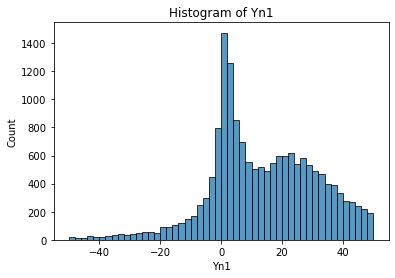

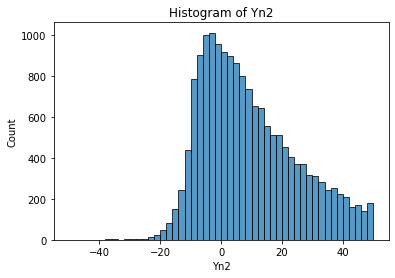

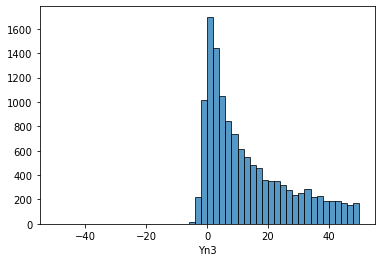

In [34]:
# Plot histogram of Yn1
plt.hist(Y_n1, bins=50, range = (-50,50), edgecolor='black', alpha=0.75)
plt.xlabel('Yn1')
plt.ylabel('Count')
plt.title('Histogram of Yn1')
plt.show()

# Plot histogram of Yn2
plt.hist(Y_n2, bins=50,range = (-50,50), edgecolor='black', alpha=0.75)
plt.xlabel('Yn2')
plt.ylabel('Count')
plt.title('Histogram of Yn2')
plt.show()

# Plot histogram of Yn3
plt.hist(Y_n3, bins=50,range = (-50,50), edgecolor='black', alpha=0.75)
plt.xlabel('Yn3')
plt.show()

#Simulate M

\begin{align*}
            &M_{n1}=\mathbf{1}\Big \{\sum_{p=1}^{5} \exp(X_{np})+\sum_{p=1}^{5}\sum_{p^{\prime}=1}^{5}X_{np} X_{np^{\prime}}^{2}+\sin^{3}(U_{n1})+U_{n2} + \exp(Y_{n1})> \lambda_{1} \} \\
            &M_{n2}=\mathbf{1}\Big \{\sum_{p=1}^{5} X_{np}^{3}+\sum_{p=1}^{5}\sum_{p^{\prime}=1}^{5}X_{np}X_{np^{\prime}}+U_{n1}+ \frac{1}{2}\cdot Y_{n1}^{3}+Y_{n2}>\lambda_{2} \} \\
            &  M_{n3}=\mathbf{1}\Big \{\sum_{p=1}^{5}p\cdot X_{np}+\sum_{p=1}^{5}\sum_{p^{\prime}=1}^{5}\sum_{p^{\prime\prime}=1}^{5}X_{np} X_{np^{\prime}}X_{np^{\prime\prime}}+\sin(U_{n1})\cdot U_{n2} + Y_{n1} + \exp(Y_{n2}) > \lambda_{3} \}. 
\end{align*}






In [35]:
maskrate = 0.3

def missing_dataset_indicator(X, U, Y, lambda1, lambda2, lambda3, single = True):
    n = X.shape[0]
    M = np.zeros((n, 3))
    M_lamda = np.zeros((n, 3))

    for i in range(n):
        sum1 = 0
        for p in range(1,6):
          for p_2 in range(1,6):
            sum1 += X[i,p-1] * np.power(X[i,p_2-1],2)
          
        sum2 = 0
        for p in range(1,6):
          for p_2 in range(1,6):
            sum2 += X[i,p-1] * X[i,p_2-1]

        sum3 = 0
        for p in range(1,6):
            sum3 += p * X[i,p-1] 

        sum4 = 0
        for p in range(1,6):
          for p_2 in range(1,6):
            for p_3 in range(1,6):
              sum4 += X[i,p-1] * X[i,p_2-1] * X[i,p_3-1]

        M_lamda[i][0] = np.exp(X[i, :]).sum() + sum1 + np.sin(U[i, 0])**3 + U[i, 1] + np.exp(Y[i, 0])

        M_lamda[i][1] = ((X[i, :]**3).sum() + sum2 + U[i, 0] + (Y[i, 0]**3)/2 + Y[i, 1])

        M_lamda[i][2] = (sum3 + sum4 + np.sin(U[i, 0]) * U[i, 1] + Y[i, 0] + np.exp(Y[i, 1]))

    
    # calculate 1 - Maskrate percentile
    lambda1 = np.percentile(M_lamda[:,0], 100 * (1-maskrate))
    lambda2 = np.percentile(M_lamda[:,1], 100 * (1-maskrate))
    lambda3 = np.percentile(M_lamda[:,2], 100 * (1-maskrate))
        
    for i in range(N):
        if (np.exp(X[i, :]).sum() + sum1 + np.sin(U[i, 0])**3 + U[i, 1] + np.exp(Y[i, 0])) > lambda1:
          M[i][0] = 1 - single
        else:
          M[i][0] = 0
        
        if ((X[i, :]**3).sum() + sum2 + U[i, 0] + (Y[i, 0]**3)/2 + Y[i, 1]) > lambda2:
          M[i][1] =  1 - single
        else:
          M[i][1] =  0

        if (sum3 + sum4 + np.sin(U[i, 0]) * U[i, 1] + Y[i, 0] + np.exp(Y[i, 1])) > lambda3:
          M[i][2] =  1
        else:
          M[i][2] =  0

    return M,M_lamda

M,M_lamda = missing_dataset_indicator(X,U,Y,lambda1,lambda2,lambda3)
display(pd.DataFrame(M))
print(M_lamda)


<ipython-input-35-d1ae7282fadf>:33: RuntimeWarning: overflow encountered in exp
  M_lamda[i][2] = (sum3 + sum4 + np.sin(U[i, 0]) * U[i, 1] + Y[i, 0] + np.exp(Y[i, 1]))
<ipython-input-35-d1ae7282fadf>:29: RuntimeWarning: overflow encountered in exp
  M_lamda[i][0] = np.exp(X[i, :]).sum() + sum1 + np.sin(U[i, 0])**3 + U[i, 1] + np.exp(Y[i, 0])
<ipython-input-35-d1ae7282fadf>:52: RuntimeWarning: overflow encountered in exp
  if (sum3 + sum4 + np.sin(U[i, 0]) * U[i, 1] + Y[i, 0] + np.exp(Y[i, 1])) > lambda3:
<ipython-input-35-d1ae7282fadf>:42: RuntimeWarning: overflow encountered in exp
  if (np.exp(X[i, :]).sum() + sum1 + np.sin(U[i, 0])**3 + U[i, 1] + np.exp(Y[i, 0])) > lambda1:


,0,1,2
0,0.0,0.0,1.0
1,0.0,0.0,0.0
2,0.0,0.0,1.0
3,0.0,0.0,0.0
4,0.0,0.0,0.0
...,...,...,...
19995,0.0,0.0,0.0
19996,0.0,0.0,1.0
19997,0.0,0.0,1.0
19998,0.0,0.0,0.0


[[ 5.61711424e+03  3.59724022e+02  6.06132974e+11]
 [-3.36973211e+00 -2.73933484e+02 -1.68606067e+01]
 [ 4.07945312e+40  4.08870269e+05  2.71124028e+13]
 ...
 [ 9.93127574e+14  2.06234340e+04  2.14865827e+11]
 [-2.07911824e+01 -3.08948777e+02 -5.46777175e+01]
 [ 1.58899976e+39  3.67979817e+05  1.42369240e+81]]


[ 5.61711424e+03 -3.36973211e+00  4.07945312e+40 ...  9.93127574e+14
 -2.07911824e+01  1.58899976e+39]
[5.61711424e+03 3.59724022e+02 6.06132974e+11]


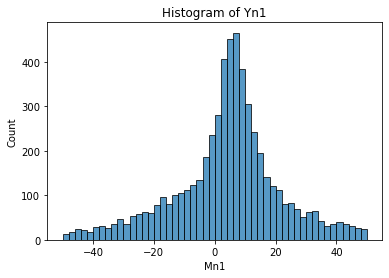

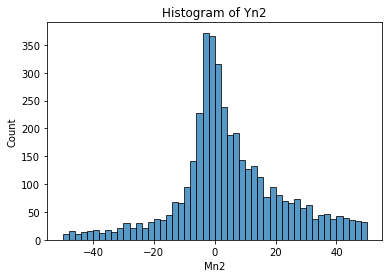

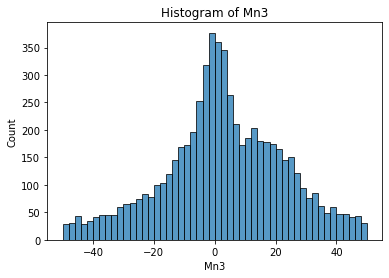

In [36]:
# Plot histogram of Mn1
print(M_lamda[:,0])
print(M_lamda[0,:])

plt.hist(M_lamda[:,0], bins=50, range = (-50,50), edgecolor='black', alpha=0.75)
plt.xlabel('Mn1')
plt.ylabel('Count')
plt.title('Histogram of Yn1')
plt.show()

# Plot histogram of Mn2
plt.hist(M_lamda[:,1], bins=50, range = (-50,50), edgecolor='black', alpha=0.75)
plt.xlabel('Mn2')
plt.ylabel('Count')
plt.title('Histogram of Yn2')
plt.show()

# Plot histogram of Mn3
plt.hist(M_lamda[:,2], bins=50, range = (-50,50), edgecolor='black', alpha=0.75)
plt.xlabel('Mn3')
plt.ylabel('Count')
plt.title('Histogram of Mn3')
plt.show()

In [37]:
print(M[:,0].sum() / N)

print(M[:,1].sum() / N)

print(M[:,2].sum() / N)

0.0
0.0
0.3


# Demonstate the Dataframe


In [41]:
Y_masked = np.ma.masked_array(Y, mask=M)
Y_masked = Y_masked.filled(np.nan)
df = pd.DataFrame(np.concatenate((Z, X, Y_masked,S), axis=1))
df.columns = ['Z', 'X1', 'X2', 'X3', 'X4', 'X5', 'Y1', 'Y2', 'Y3', 'S']
display(df)
df.to_csv('Sample_data.csv', index=False)
df.describe()

,Z,X1,X2,X3,X4,X5,Y1,Y2,Y3,S
0,0.0,-0.326961,0.681237,0.572757,0.972337,1.0,8.630339,27.130365,NaN,1.0
1,0.0,-0.040921,-1.539536,-1.291422,-0.055612,1.0,-8.101551,-7.639062,16.503150,1.0
2,1.0,-0.469732,-1.923845,2.555196,1.540086,0.0,93.509367,30.931012,NaN,1.0
3,1.0,-1.446587,-1.906561,0.082916,0.962741,1.0,20.253254,-10.242290,8.966378,1.0
4,1.0,-0.871941,-1.818314,-0.439823,1.517108,0.0,18.065648,-10.956299,16.051422,1.0
...,...,...,...,...,...,...,...,...,...,...
19995,0.0,0.518921,-0.419175,0.800085,0.531602,0.0,2.805554,9.714876,14.652438,100.0
19996,1.0,0.830509,-1.681961,0.630414,2.638560,0.0,100.307291,49.244602,NaN,100.0
19997,1.0,0.928814,0.636726,0.600920,0.435804,0.0,34.531880,26.093280,NaN,100.0
19998,1.0,-0.235964,-2.124764,-1.626390,0.588759,0.0,-8.420992,-9.769561,44.323274,100.0


,Z,X1,X2,X3,X4,X5,Y1,Y2,Y3,S
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,14000.000000,20000.000000
mean,0.500300,0.499491,-0.339920,-0.012796,0.568819,0.330550,27.571811,34.027473,17.893815,50.500000
std,0.500012,0.989028,1.007960,0.987792,0.997046,0.470423,82.224588,244.004579,23.541183,28.866792
min,0.000000,-3.240463,-4.655910,-5.964742,-6.275647,0.000000,-434.335461,-52.548251,-6.673000,1.000000
25%,0.000000,-0.170599,-1.015062,-0.495027,0.087944,0.000000,2.334338,-1.453266,2.693011,25.750000
50%,1.000000,0.498201,-0.333832,-0.004147,0.575386,0.000000,17.308686,10.299212,9.921159,50.500000
75%,1.000000,1.170738,0.336868,0.474488,1.056805,1.000000,36.005756,32.050077,25.946708,75.250000
max,1.000000,4.560368,3.974212,6.931643,6.984746,1.000000,5112.555616,22000.707382,459.675887,100.000000


# Save all the simulated data


In [39]:
# Read the data,it is important to put the "Research" directory in ones own google drive
Z = Z.reshape((-1,1))

np.save("/Users/jiaweizhang/research/data/X.npy", X)
np.save("/Users/jiaweizhang/research/data/Y.npy", Y)
np.save("/Users/jiaweizhang/research/data/Z.npy", Z)
np.save("/Users/jiaweizhang/research/data/U.npy", U)
np.save("/Users/jiaweizhang/research/data/M.npy", M)
np.save("/Users/jiaweizhang/research/data/S.npy", S)

print(X.shape)
display(pd.DataFrame(X))
print(pd.DataFrame(X).describe())
print(Y.shape)
display(pd.DataFrame(Y))
print(pd.DataFrame(Y).describe())
print(Z.shape)
display(pd.DataFrame(Z))
print(pd.DataFrame(Z).describe())
print(U.shape)
display(pd.DataFrame(U))
print(pd.DataFrame(U).describe())
print(M.shape)
display(pd.DataFrame(M))
print(pd.DataFrame(M).describe())
print(S.shape)
display(pd.DataFrame(S))
print(pd.DataFrame(S).describe())

print("Sucessfully Saved")

(20000, 5)


,0,1,2,3,4
0,-0.326961,0.681237,0.572757,0.972337,1.0
1,-0.040921,-1.539536,-1.291422,-0.055612,1.0
2,-0.469732,-1.923845,2.555196,1.540086,0.0
3,-1.446587,-1.906561,0.082916,0.962741,1.0
4,-0.871941,-1.818314,-0.439823,1.517108,0.0
...,...,...,...,...,...
19995,0.518921,-0.419175,0.800085,0.531602,0.0
19996,0.830509,-1.681961,0.630414,2.638560,0.0
19997,0.928814,0.636726,0.600920,0.435804,0.0
19998,-0.235964,-2.124764,-1.626390,0.588759,0.0


                  0             1             2             3             4
count  20000.000000  20000.000000  20000.000000  20000.000000  20000.000000
mean       0.499491     -0.339920     -0.012796      0.568819      0.330550
std        0.989028      1.007960      0.987792      0.997046      0.470423
min       -3.240463     -4.655910     -5.964742     -6.275647      0.000000
25%       -0.170599     -1.015062     -0.495027      0.087944      0.000000
50%        0.498201     -0.333832     -0.004147      0.575386      0.000000
75%        1.170738      0.336868      0.474488      1.056805      1.000000
max        4.560368      3.974212      6.931643      6.984746      1.000000
(20000, 3)


,0,1,2
0,8.630339,27.130365,81.389768
1,-8.101551,-7.639062,16.503150
2,93.509367,30.931012,54.968385
3,20.253254,-10.242290,8.966378
4,18.065648,-10.956299,16.051422
...,...,...,...
19995,2.805554,9.714876,14.652438
19996,100.307291,49.244602,112.362151
19997,34.531880,26.093280,62.651544
19998,-8.420992,-9.769561,44.323274


                  0             1              2
count  20000.000000  20000.000000   20000.000000
mean      27.571811     34.027473     214.588708
std       82.224588    244.004579    3112.421316
min     -434.335461    -52.548251      -6.673000
25%        2.334338     -1.453266       5.076318
50%       17.308686     10.299212      22.801517
75%       36.005756     32.050077      87.395950
max     5112.555616  22000.707382  310188.749472
(20000, 1)


,0
0,0
1,0
2,1
3,1
4,1
...,...
19995,0
19996,1
19997,1
19998,1


                  0
count  20000.000000
mean       0.500300
std        0.500012
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        1.000000
(20000, 2)


,0,1
0,0.393202,0.0
1,0.666486,1.0
2,0.301699,0.0
3,-0.016194,1.0
4,0.427256,0.0
...,...,...
19995,2.129859,0.0
19996,-0.057244,0.0
19997,0.426492,0.0
19998,1.554902,0.0


                  0             1
count  20000.000000  20000.000000
mean       0.486349      0.668750
std        0.996454      0.470675
min       -3.289595      0.000000
25%       -0.186863      0.000000
50%        0.488639      1.000000
75%        1.158971      1.000000
max        4.789262      1.000000
(20000, 3)


,0,1,2
0,0.0,0.0,1.0
1,0.0,0.0,0.0
2,0.0,0.0,1.0
3,0.0,0.0,0.0
4,0.0,0.0,0.0
...,...,...,...
19995,0.0,0.0,0.0
19996,0.0,0.0,1.0
19997,0.0,0.0,1.0
19998,0.0,0.0,0.0


             0        1             2
count  20000.0  20000.0  20000.000000
mean       0.0      0.0      0.300000
std        0.0      0.0      0.458269
min        0.0      0.0      0.000000
25%        0.0      0.0      0.000000
50%        0.0      0.0      0.000000
75%        0.0      0.0      1.000000
max        0.0      0.0      1.000000
(20000, 1)


,0
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0
...,...
19995,100.0
19996,100.0
19997,100.0
19998,100.0


                  0
count  20000.000000
mean      50.500000
std       28.866792
min        1.000000
25%       25.750000
50%       50.500000
75%       75.250000
max      100.000000
Sucessfully Saved
